![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


filename_features = "./Dados/UCI HAR Dataset/features.txt"
filename_labels   = "./Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain   = "./Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain   = "./Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest  = "./Dados/UCI HAR Dataset/test/subject_test.txt"
filename_xtest    = "./Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest    = "./Dados/UCI HAR Dataset/test/y_test.txt"

# --- Features ---
features = pd.read_csv(filename_features, sep=r"\s+", header=None, names=['id', 'nome_var'])
nomes_features = features['nome_var']

# Corrige duplicatas nos nomes
nomes_features = pd.Index(nomes_features)
if nomes_features.duplicated().any():
    nomes_features = nomes_features.to_series().where(~nomes_features.duplicated(),
                                                      nomes_features.to_series() + "_" + nomes_features.to_series().groupby(nomes_features).cumcount().astype(str))

nomes_features = nomes_features.tolist()

# --- Labels ---
labels = pd.read_csv(filename_labels, sep=r"\s+", header=None, names=['cod_label', 'label'])

# --- Conjunto de treino ---
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, sep=r"\s+", header=None, names=nomes_features)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

# --- Conjunto de teste ---
subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, sep=r"\s+", header=None, names=nomes_features)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

In [87]:
print(f'X_train {X_train.shape}')
print(f'X_test {X_test.shape}')
print(f'y_train {y_train.shape}')
print(f'y_test {y_test.shape}')

X_train (7352, 561)
X_test (2947, 561)
y_train (7352, 1)
y_test (2947, 1)


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [90]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)

CPU times: total: 250 ms
Wall time: 256 ms


In [91]:
pca = PCA()

# PCA sem padronizar
pca_raw = pca.fit(X_train)

var_explicada = pca_raw.explained_variance_
var_percentual = pca_raw.explained_variance_ratio_
var_acumulada = np.cumsum(var_percentual)

# PCA padronizada
pca_pad = pca.fit(X_train_pad)

var_explicada_pad = pca_pad.explained_variance_
var_percentual_pad = pca_pad.explained_variance_ratio_
var_acumulada_pad = np.cumsum(var_percentual_pad)


tabela_comparacao = pd.DataFrame({
    "Variância explicada (sem pad)": var_explicada[:15],
    "Variância % (sem pad)": var_percentual[:15] * 100,
    "Soma acumulada % (sem pad)": var_acumulada[:15] * 100,
    "Variância explicada (com pad)": var_explicada_pad[:15],
    "Variância % (com pad)": var_percentual_pad[:15] * 100,
    "Soma acumulada % (com pad)": var_acumulada_pad[:15] * 100,
})

df_tabela = pd.DataFrame(tabela_comparacao.round(2))
df_tabela

,Variância explicada (sem pad),Variância % (sem pad),Soma acumulada % (sem pad),Variância explicada (com pad),Variância % (com pad),Soma acumulada % (com pad)
0,34.82,62.55,62.55,284.88,50.78,50.78
1,2.74,4.91,67.47,36.92,6.58,57.36
2,2.29,4.12,71.59,15.74,2.81,60.17
3,1.04,1.87,73.46,14.05,2.50,62.67
4,0.94,1.69,75.16,10.59,1.89,64.56
5,0.71,1.27,76.43,9.67,1.72,66.28
6,0.66,1.18,77.61,7.69,1.37,67.66
7,0.60,1.07,78.68,6.73,1.20,68.85
8,0.54,0.97,79.65,5.59,1.00,69.85
9,0.48,0.86,80.50,5.41,0.97,70.82


## Interpretação dos dados

### Colunas
- **Variância explicada** → variância bruta explicada por cada componente.
- **Variância %** → importância relativa de cada componente individualmente.
- **Soma acumulada %** → importância acumulada até aquele componente.

**Colunas sem pad** → PCA feito direto nos dados originais (escala desigual influencia).

**Colunas com pad** → PCA feito nos dados padronizados (todas variáveis com mesmo peso).

### Conclusão
As variâncias **sem padronização** aparentam ser mais eficientes, já que a **soma acumulada** atinge altos níveis de explicação com poucos componentes.  
Entretanto, essa eficiência é ilusória: variáveis com maior escala ou variabilidade numérica acabam dominando os primeiros componentes, gerando um resultado enviesado.  

Por outro lado, ao aplicar a **padronização**, todas as variáveis passam a ter a mesma escala, impedindo que algumas se sobressaiam apenas pelo tamanho da sua variância.  
O resultado é uma representação mais justa e equilibrada do conjunto de dados, embora seja necessário utilizar um número maior de componentes para atingir o mesmo nível de variância explicada.  


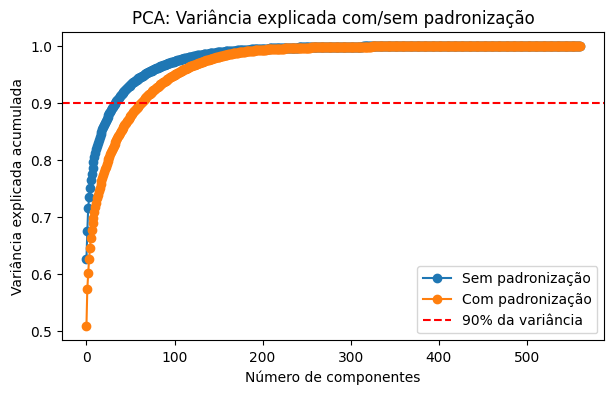

Componentes necessários para 90% sem padronização: 34
Componentes necessários para 90% com padronização: 63


In [95]:
plt.figure(figsize=(7,4))
plt.plot(var_acumulada, marker='o', label='Sem padronização')
plt.plot(var_acumulada_pad, marker='o', label='Com padronização')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% da variância')
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.title('PCA: Variância explicada com/sem padronização')
plt.legend()
plt.show()

comp_90_sem_pad = np.argmax(var_acumulada >= 0.90) + 1
comp_90_com_pad = np.argmax(var_acumulada_pad >= 0.90) + 1

print(f'Componentes necessários para 90% sem padronização: {comp_90_sem_pad}')
print(f'Componentes necessários para 90% com padronização: {comp_90_com_pad}')

### Análise para alcançar 90% dos componentes

Para atingir **90% da variância explicada**, são necessários:

- **Sem padronização**: 34 componentes (~7% do total de variáveis)  
- **Com padronização**: 63 componentes (~11% do total de variáveis)  

Esse resultado reforça a conclusão anterior: a **padronização** demanda um número maior de componentes, mas evita o viés causado por variáveis de maior escala.  
Dessa forma, garante uma **distribuição mais equilibrada** da variância entre todas as variáveis, representando melhor a estrutura do conjunto de dados.


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [99]:
def arvore_comparacao(n_components, treino, teste, modelo):
    resultados = []
    
    start = time.time()
    
    prcomp = PCA(n_components=n_components).fit(treino)
    
    X_pca_train = prcomp.transform(treino)
    X_pca_test = prcomp.transform(teste)
    
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001).fit(X_pca_train, y_train)
    
    train_score_pca = clf.score(X_pca_train, y_train)
    test_score_pca = clf.score(X_pca_test, y_test)
    
    end = time.time()
    
    resultados.append({
        'Modelo': modelo,
        'Acurácia Treino': f'{train_score_pca*100:.2f}%',
        'Acurácia Teste': f'{test_score_pca*100:.2f}%',
        'Tempo de execução (s)': f'{end - start:.2f}s'
    })

    df_resultado = pd.DataFrame(resultados)
    return df_resultado

In [106]:
sem_pad = arvore_comparacao(10, X_train, X_test, 'Sem Padronização')
com_pad = arvore_comparacao(10, X_train_pad, X_test_pad, 'Com padronização')

df_comp_pad = pd.concat([sem_pad, com_pad], axis=0)
df_comp_pad

,Modelo,Acurácia Treino,Acurácia Teste,Tempo de execução (s)
0,Sem Padronização,89.27%,82.42%,0.19s
0,Com padronização,85.87%,77.37%,0.17s


## Conclusão

O modelo ```sem padronização``` manteve um desempenho melhor, tanto no **treino** quanto em **teste**, com apenas *0.02 segundos* a mais que o ```padronizado```.

Isso demonstra que com poucos componentes, mesmo estando enviesado, o modelo não padronizado demonstrou melhor performance; visto que o custo computacional é irrisório neste caso.

Com a padronização, o mododelo exige mais componentes para chegar ao mesmo nível de explicação, porém é mais justo e equilibrado.